# Setup

In [1]:
!pip install keras-tuner statsmodels

import os
import sys
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import tensorflow as tf
import tensorboard as tb
from tensorflow.keras.callbacks import TensorBoard
import matplotlib_inline
from matplotlib import pyplot as plt

# set styles
%matplotlib notebook
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.style.use('/kaggle/input/proplot-stylesheet/proplot_style.mplstyle')

# allocate TPU
try:
    raise ValueError('Skip - use GPU')
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print('Could not start a TPU. Falling back to GPU.')
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# set up TensorBoard
log_dir = "model_logs/fit"  # Specify the directory for storing TensorBoard logs

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # frequency (in epochs) for computing histograms
    write_graph=True,  # whether to write the model graph visualization
    update_freq='epoch'  # frequency (in 'batch' or 'epoch') for writing TensorBoard summaries
)

# import all modules
import os
import datetime as dt
from matplotlib.ticker import AutoMinorLocator, NullFormatter
import numpy as np
import pandas as pd
import statsmodels as sm
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, MaxPooling1D, MaxPooling2D, TimeDistributed, Reshape, Flatten, Dense, Dropout, LSTM, Conv1D, Conv2D
from tensorflow.keras.callbacks import TensorBoard
from keras_tuner.tuners import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters


# set paths to data sources
BASE_PATH = '/kaggle/input/eit-touch-sensor-datasets'
DATA_SOURCE_1 = 'EIT_Data_Gelatin_1_finger_2_dof - SN.xlsx'
DATA_SOURCE_2 = 'EIT_Data_Gelatin_2_fingers_4_dof - SN.xlsx'

/kaggle/input/proplot-stylesheet/proplot_style.mplstyle
/kaggle/input/eit-touch-sensor-datasets/EIT_Data_Gelatin_1_finger_2_dof - SN.xlsx
/kaggle/input/eit-touch-sensor-datasets/EIT_Data_Gelatin_1_finger_2_dof - ND.xlsx
/kaggle/input/eit-touch-sensor-datasets/EIT_Data_Gelatin_2_fingers_4_dof - SN.xlsx


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Could not start a TPU. Falling back to GPU.
Num GPUs Available:  1


# Import Data

In [2]:
X = pd.read_excel(os.path.join(BASE_PATH, DATA_SOURCE_1), sheet_name='Voltages')
y_orig = pd.read_excel(os.path.join(BASE_PATH, DATA_SOURCE_1), sheet_name='Positions')
y_orig.dropna(axis=1, how='all', inplace=True)
print(X.shape, y_orig.shape)  # expect: x: (3200, 1024), y_orig: (3200, 2)

X2 = pd.read_excel(os.path.join(BASE_PATH, DATA_SOURCE_2), sheet_name='Voltages')
y2_orig = pd.read_excel(os.path.join(BASE_PATH, DATA_SOURCE_2), sheet_name='Positions')
print(X2.shape, y2_orig.shape)

(3199, 1024) (3199, 2)
(1600, 1024) (1600, 4)


# Process Data

In [3]:
FRAME_X, FRAME_Y, GRID_DIV_X, GRID_DIV_Y = 0.08, 0.12, 6, 8

def convert_xy_to_disp_map(positions: list | np.ndarray) -> np.ndarray:
    '''
    Given a set of frame coordinates, return an image-like array showing
    the position of the fingers. It is OK for some of the values to be None,
    which represent empty positions.
        
    ### Arguments
    #### Required
    - `positions` (list | np.ndarray): list of position coordinates
    [x0, x1, ..., y0, y1, ...], in metres in the frame coordinates.
    Shape: (num_trials, 2 * num_fingers) or can be (2 * num_fingers,) if only one.
    #### Optional
        
    ### Returns
    - `np.ndarray`: array of images showing the finger positions. Each array
    will be 1 if there is a press within that tile, and 0 otherwise.
    The radius of the finger is neglected.
    Shape: (num_trials, self.GRID_DIV_X, self.GRID_DIV_Y) or
    (self.GRID_DIV_X, self.GRID_DIV_Y) if only one.
    '''

    tile_x = FRAME_X / GRID_DIV_X
    tile_y = FRAME_Y / GRID_DIV_Y

    if isinstance(positions, list):
        positions = np.array(positions)
    if positions.ndim == 1:
        positions = positions.reshape(1, -1)

    disp_maps = []
    for pos in positions:
        pos = pos[~np.isnan(pos)]  # remove None entries, preserve order
        disp_map = np.zeros((GRID_DIV_X, GRID_DIV_Y))
        x_list = pos[:len(pos) // 2]
        y_list = pos[len(pos) // 2:]
        for x, y in zip(x_list, y_list):
            disp_map[int(x // tile_x), int(y // tile_y)] = 1.0
        disp_maps.append(disp_map)
    return np.array(disp_maps) if len(disp_maps) > 1 else disp_maps[0]

y = convert_xy_to_disp_map(y_orig.values)
print(y.shape)  # expect: (3200, 6, 8)
print(y[0, ...])

y2 = convert_xy_to_disp_map(y2_orig.values)
print(y2.shape)
print(y2[0, ...])

(3199, 6, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
(1600, 6, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [5]:
# train a series of regression models:
# simple linear, polynomial, lasso, ridge, random forest, svr, knn, mlp
# PCA is used for poly/ridge/lasso

pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),
    ('regression', LinearRegression())
])

pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),
    ('poly', PolynomialFeatures()),
    ('regression', LinearRegression())
])

pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge())
])

# hyperparameter key syntax: 'name in pipeline__attribute'
param_grid_linear = {'pca__n_components': [2, 10, 128, 1024]}
param_grid_poly = {'poly__degree': [2]}
param_grid_ridge = {'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]}

def train_model(X: np.ndarray, y: np.ndarray, pipeline: Pipeline, param_grid: dict[str: list],
        model_name: str = '', test_size: float = 0.2, cv: int = 10,
        scoring: str = 'neg_mean_squared_error') -> Pipeline:
    '''
    Train and evaluate a model using grid search cross validation.
    
    #### Arguments
    
    `X` (np.ndarray): full input dataset (features)
    `y` (np.ndarray): full output dataset (target variable)
    `pipeline` (Pipeline): sequence of processing steps and a final estimator.
    `param_grid` (dict[str: list]): set of hyperparameters to search over.
    Key syntax: 'name in pipeline__attribute'
    `test_size` (float, default = 0.2): proportion of dataset to use for testing.
    `cv` (int, default = 10): number of folds in cross validation.
    `scoring` (str, default = 'neg_mean_squared_error'): scoring metric for cross validation.
    
    #### Returns
    
    `Pipeline`: the best model found by grid search cross validation.
    '''

    mape = lambda y_test, y_pred: round(mean_absolute_percentage_error(y_test, y_pred), 5)
    mae = lambda y_test, y_pred: round(mean_absolute_error(y_test, y_pred), 5)
    rmse = lambda y_test, y_pred: round(mean_squared_error(y_test, y_pred, squared=False), 5)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring=scoring)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f'{model_name} - Best hyperparameters: {search.best_params_}')
    print(f'MAPE: {mape(y_test, y_pred)}, '
          f'MAE: {mae(y_test, y_pred)}, '
          f'RMSE: {rmse(y_test, y_pred)}')
    return best_model


linear_model = train_model(X, y_orig, pipeline_linear, param_grid_linear, model_name='Linear')
poly_model = train_model(X, y_orig, pipeline_poly, param_grid_poly, model_name='Poly')
ridge_model = train_model(X, y_orig, pipeline_ridge, param_grid_ridge, model_name='Ridge')

Linear - Best hyperparameters: {'pca__n_components': 128}
MAPE: 0.4024, MAE: 0.01411, RMSE: 0.01737
Poly - Best hyperparameters: {'poly__degree': 2}
MAPE: 0.70217, MAE: 0.02798, RMSE: 0.04931
Ridge - Best hyperparameters: {'ridge__alpha': 5.0}
MAPE: 0.85433, MAE: 0.03097, RMSE: 0.05184


In [6]:
# get test/train sets: 80:10:10 train:val:test split
X_train, X_test, y_pos_train, y_pos_test = train_test_split(X, y_orig, test_size=1/10)
X_train, X_val, y_pos_train, y_pos_val = train_test_split(X_train, y_pos_train, test_size=1/9)

print(X_train.shape, X_val.shape, X_test.shape, y_pos_train.shape, y_pos_val.shape, y_pos_test.shape)

(2559, 1024) (320, 1024) (320, 1024) (2559, 2) (320, 2) (320, 2)


Trial 1 Complete [00h 00m 42s]
val_loss: 0.00020329467952251434

Best val_loss So Far: 0.00020329467952251434
Total elapsed time: 00h 00m 42s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 270,690
Trainable params: 270,690
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
20/20 [==============================] - 2s 25ms/step - loss: 4.1335e-05 - val_loss: 2.0391e-04
Epoch 2/200
20/20 [==============================] - 0s 11ms/ste

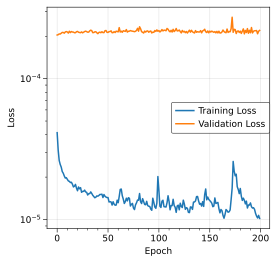

10/10 [==============================] - 0s 3ms/step - loss: 2.6476e-04
{'units_1': 256, 'units_2': 32}
0.0002647594374138862


In [4]:
def build_fcnn_model(hp: HyperParameters) -> Sequential:
    model_fcnn = Sequential()
    model_fcnn.add(Input(shape=(1024,)))
    model_fcnn.add(Dense(units=hp.Int('units_1', min_value=256, max_value=256, step=128), activation='relu'))
    model_fcnn.add(Dense(units=hp.Int('units_2', min_value=32, max_value=32, step=128), activation='relu'))
    model_fcnn.add(Dense(units=2, activation='linear'))
    model_fcnn.compile(optimizer='adam', loss='mse')
    model_fcnn.summary()
    return model_fcnn

tuner = BayesianOptimization(build_fcnn_model, objective='val_loss', max_trials=1,
                             directory='tuner_dir', project_name='my_tuner')

# train : validation : test split = 80 : 10 : 10
X_train, X_test, y_pos_train, y_pos_test = train_test_split(X, y_orig, test_size=1/10)
X_train, X_val, y_pos_train, y_pos_val = train_test_split(X_train, y_pos_train, test_size=1/9)

tuner.search(X_train, y_pos_train, epochs=100, validation_data=(X_val, y_pos_val))
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# train best model
best_history = best_model.fit(X_train, y_pos_train, epochs=200, batch_size=128,
    validation_data=(X_val, y_pos_val), callbacks=[tensorboard_callback])
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# test best model
best_loss = best_model.evaluate(X_test, y_pos_test)
print(best_hyperparameters.values)
print(best_loss)

# save best model
best_model.save('models-4-dof/fcnn_1_finger.keras')

1/1 [==============================] - 0s 21ms/step


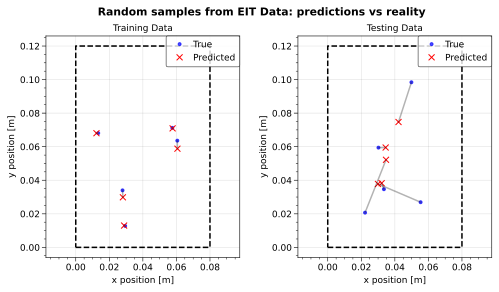

In [10]:
fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Random samples from EIT Data: predictions vs reality')
ax_train.set_title('Training Data')
ax_train.set_xlabel('x position [m]')
ax_train.set_ylabel('y position [m]')
ax_test.set_title('Testing Data')
ax_test.set_xlabel('x position [m]')
ax_test.set_ylabel('y position [m]')
ax_train.set_xlim([0, FRAME_X])
ax_train.set_ylim([0, FRAME_Y])
ax_test.set_xlim([0, FRAME_X])
ax_test.set_ylim([0, FRAME_Y])

best_model = load_model('models-4-dof/fcnn_1_finger.keras')

# choose 5 random rows from the training and testing sets each
samples_i = np.random.choice(X_train.shape[0], 5, replace=False)
X_sample_train = X_train.iloc[samples_i].values
y_sample_train = y_pos_train.iloc[samples_i].values
y_pred_train = best_model.predict(X_sample_train)

samples_i = np.random.choice(X_test.shape[0], 5, replace=False)
X_sample_test = X_test.iloc[samples_i].values
y_sample_test = y_pos_test.iloc[samples_i].values
y_pred_test = best_model.predict(X_sample_test)

# plot training data
ax_train.plot(y_sample_train[:, 0], y_sample_train[:, 1], 'b.', label=f'True', alpha=0.7)
ax_train.plot(y_pred_train[:, 0], y_pred_train[:, 1], 'rx', label=f'Predicted')
for i in range(len(y_sample_train)):
    ax_train.plot([y_sample_train[i, 0], y_pred_train[i, 0]], [y_sample_train[i, 1], y_pred_train[i, 1]],
        'k-', alpha=0.3)
ax_train.plot([0, FRAME_X, FRAME_X, 0, 0], [0, 0, FRAME_Y, FRAME_Y, 0], 'k--')
ax_train.axis('equal')
ax_train.legend(loc='upper right')

# plot test data
ax_test.plot(y_sample_test[:, 0], y_sample_test[:, 1], 'b.', label=f'True', alpha=0.7)
ax_test.plot(y_pred_test[:, 0], y_pred_test[:, 1], 'rx', label=f'Predicted')
for i in range(len(y_sample_test)):
    ax_test.plot([y_sample_test[i, 0], y_pred_test[i, 0]], [y_sample_test[i, 1], y_pred_test[i, 1]],
        'k-', alpha=0.3)
ax_test.plot([0, FRAME_X, FRAME_X, 0, 0], [0, 0, FRAME_Y, FRAME_Y, 0], 'k--')
ax_test.axis('equal')
ax_test.legend(loc='upper right')

plt.subplots_adjust(wspace=0.3)
plt.show()

# Split image datasets

In [15]:
# get test/train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(2559, 1024) (320, 1024) (320, 1024) (2559, 6, 8) (320, 6, 8) (320, 6, 8)


Epoch 1/10


2023-08-27 18:29:23.283669: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 [==============================] - 3s 67ms/step - loss: 0.3240 - accuracy: 0.1372 - val_loss: 0.3242 - val_accuracy: 0.1474
Epoch 2/10
20/20 [==============================] - 1s 52ms/step - loss: 0.3099 - accuracy: 0.0600 - val_loss: 0.2436 - val_accuracy: 0.0172
Epoch 3/10
20/20 [==============================] - 1s 52ms/step - loss: 0.1584 - accuracy: 0.0231 - val_loss: 0.1068 - val_accuracy: 0.0271
Epoch 4/10
20/20 [==============================] - 1s 52ms/step - loss: 0.1013 - accuracy: 0.0273 - val_loss: 0.0977 - val_accuracy: 0.0208
Epoch 5/10
20/20 [==============================] - 1s 66ms/step - loss: 0.0967 - accuracy: 0.0269 - val_loss: 0.0955 - val_accuracy: 0.0344
Epoch 6/10
20/20 [==============================] - 1s 67ms/step - loss: 0.0953 - accuracy: 0.0272 - val_loss: 0.0948 - val_accuracy: 0.0250
Epoch 7/10
20/20 [==============================] - 1s 53ms/step - loss: 0.0946 - accuracy: 0.0275 - val_loss: 0.0948 - val_accuracy: 0.0245
Epoch 8/10
20/20 [======

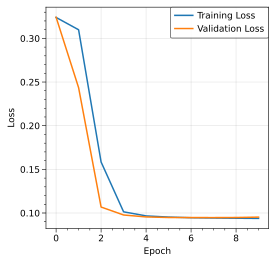

10/10 [==============================] - 0s 4ms/step - loss: 0.0932 - accuracy: 0.0292
{'units_1': 256, 'size_1': 3, 'units_2': 64, 'size_2': 7}
[0.0931934267282486, 0.02916666679084301]


In [19]:
def build_convnet_model(hp: HyperParameters) -> Sequential:
    model_cnn = Sequential()
    model_cnn.add(Input(shape=(1024,)))
    model_cnn.add(Reshape((32, 32, 1)))
    model_cnn.add(Conv2D(hp.Int('units_1', min_value=256, max_value=1024, step=256),
        kernel_size=hp.Choice('size_1', [3, 5, 9]), activation='relu'))
    model_cnn.add(Conv2D(hp.Int('units_2', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('size_2', [5, 7, 13]), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128, activation='relu'))
    model_cnn.add(Dense(6 * 8, activation='sigmoid'))
    model_cnn.add(Reshape((6, 8)))
    model_cnn.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics=['accuracy'])
    return model_cnn

tuner = BayesianOptimization(build_convnet_model, objective='val_loss',
                             max_trials=5, directory='tuner_dir',
                             project_name='my_cnn_tuner')

# find best hyperparameters - use 100 epochs instead of 200 to save time
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# train best model
best_history = best_model.fit(X_train, y_train, epochs=10, batch_size=128,
    validation_data=(X_val, y_val), callbacks=[tensorboard_callback])
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# test best model
best_loss = best_model.evaluate(X_test, y_test)
print(best_hyperparameters.values)
print(best_loss)

# save best model
best_model.save('models-4-dof/convnet_1_finger.keras')

1/1 [==============================] - 0s 23ms/step


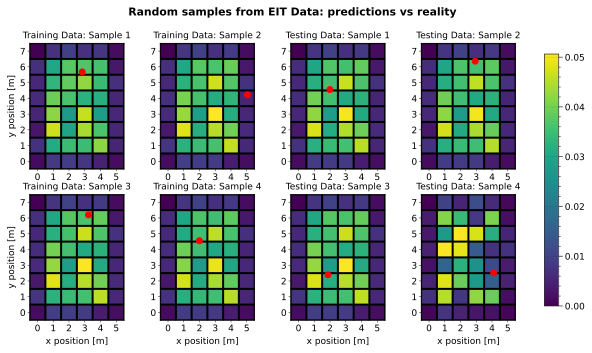

In [20]:
model_cnn = load_model('models-4-dof/convnet_1_finger.keras', compile=False)

# take 4 random samples from each of the training and testing datasets
samples_i = np.random.randint(X_train.values.shape[0], size=4)
X_sample_train = X_train.values[samples_i]
y_sample_train = y_train[samples_i]
y_pred_train = model_cnn.predict(X_sample_train)

samples_i = np.random.choice(X_test.values.shape[0], 4, replace=False)
X_sample_test = X_test.values[samples_i]
y_sample_test = y_test[samples_i]
y_pred_test = model_cnn.predict(X_sample_test)

# get corresponding positions
y_pos_sample_train = []
for y_sample in y_sample_train:
    i = y.tolist().index(y_sample.tolist())
    y_pos_sample_train.append(y_orig.values[i])
y_pos_sample_train = np.array(y_pos_sample_train)

y_pos_sample_test = []
for y_sample in y_sample_test:
    i = y.tolist().index(y_sample.tolist())
    y_pos_sample_test.append(y_orig.values[i])
y_pos_sample_test = np.array(y_pos_sample_test)

y_pos_sample_train, y_pos_sample_test = np.array(y_pos_sample_train), np.array(y_pos_sample_test)

# get corresponding tiles
xy_to_tile = lambda x, y: [x / FRAME_X * GRID_DIV_X, y / FRAME_Y * GRID_DIV_Y]
y_tile_sample_train = np.array(xy_to_tile(*y_pos_sample_train.T)).T
y_tile_sample_test = np.array(xy_to_tile(*y_pos_sample_test.T)).T

# plot results
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
fig.suptitle('Random samples from EIT Data: predictions vs reality')
ax_trains = axs[:, :2].flatten()
ax_tests = axs[:, 2:].flatten()
cbar_upper_lim = min(1, 1 * np.max(y_pred_train))

for i, ax_train in enumerate(ax_trains):
    ax_train.set_title(f'Training Data: Sample {i + 1}')
    if i in (2, 3):
        ax_train.set_xlabel('x position [m]')
    if i in (0, 2):
        ax_train.set_ylabel('y position [m]')
    ax_train.set_xlim([0, FRAME_X])
    ax_train.set_ylim([0, FRAME_Y])
    ax_train.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax_train.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax_train.tick_params(which='major', size=0, labelsize=0)
    ax_train.xaxis.set_major_formatter(NullFormatter())
    ax_train.yaxis.set_major_formatter(NullFormatter())
    ax_train.xaxis.set_minor_formatter('{x:.0f}')
    ax_train.yaxis.set_minor_formatter('{x:.0f}')
    ax_train.set_xticks(np.arange(-0.5, GRID_DIV_X + 0.5, 1))
    ax_train.set_yticks(np.arange(-0.5, GRID_DIV_Y + 0.5, 1))
    ax_train.imshow(y_pred_train[i].T, cmap='viridis', vmin=0, vmax=cbar_upper_lim)
    ax_train.plot([y_tile_sample_train[i][0]], [y_tile_sample_train[i][1]], 'ro')

for i, ax_test in enumerate(ax_tests):
    ax_test.set_title(f'Testing Data: Sample {i + 1}')
    if i in (2, 3):
        ax_test.set_xlabel('x position [m]')
    ax_test.set_xlim([0, FRAME_X])
    ax_test.set_ylim([0, FRAME_Y])
    ax_test.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax_test.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax_test.tick_params(which='major', size=0, labelsize=0)
    ax_test.xaxis.set_major_formatter(NullFormatter())
    ax_test.yaxis.set_major_formatter(NullFormatter())
    ax_test.xaxis.set_minor_formatter('{x:.0f}')
    ax_test.yaxis.set_minor_formatter('{x:.0f}')
    ax_test.set_xticks(np.arange(-0.5, GRID_DIV_X + 0.5, 1))
    ax_test.set_yticks(np.arange(-0.5, GRID_DIV_Y + 0.5, 1))
    if i == 3:  # record the last image to use for the colorbar
        im = ax_test.imshow(y_pred_test[i].T, cmap='viridis', vmin=0, vmax=cbar_upper_lim)
    else:
        ax_test.imshow(y_pred_test[i].T, cmap='viridis', vmin=0, vmax=cbar_upper_lim)
    ax_test.plot([y_tile_sample_test[i][0]], [y_tile_sample_test[i][1]], 'ro')

for ax in axs.flatten():
    ax.grid(linewidth=2, visible=True, which='major', alpha=1.0)
    ax.grid(which='minor', alpha=0.0)

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

#plt.tight_layout(rect=[0, 0, 0.8, 0.96])
plt.show()

## 2 Finger Models

Trial 5 Complete [00h 00m 42s]
val_loss: 0.0015893345698714256

Best val_loss So Far: 0.0015893345698714256
Total elapsed time: 00h 01m 51s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 320)               164160    
                                                                 
 dense_2 (Dense)             (None, 4)                 1284      
                                                                 
Total params: 690,244
Trainable params: 690,244
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
12/12 [==============================] - 2s 28ms/step - loss: 0.0014
Epoch 2/200
12/12 [==============================] - 0s 25ms/step - loss: 0.0013
Epoch 3/200


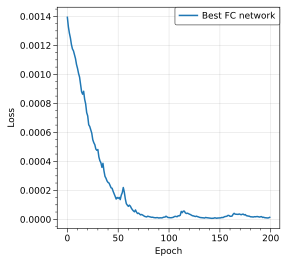

5/5 [==============================] - 0s 3ms/step - loss: 2.9937e-04
{'units_1': 512, 'units_2': 320}
0.0002993736998178065


In [33]:
# get test/train sets
X_train, X_test, y_pos_train, y_pos_test = train_test_split(X2, y2_orig, test_size=1/10)
X_train, X_val, y_pos_train, y_pos_val = train_test_split(X2, y2_orig, test_size=1/9)
print(X_train.shape, X_test.shape, y_pos_train.shape, y_pos_test.shape)

def unordered_mse(y_true, y_pred):
    from tensorflow.keras import backend as K
    loss1 = K.sum(K.square(y_true - y_pred), axis=-1)
    y_pred_reordered = tf.stack([y_pred[:, 1], y_pred[:, 0], y_pred[:, 3], y_pred[:, 2]], 
                                axis=-1)
    loss2 = K.sum(K.square(y_true - y_pred_reordered), axis=-1)
    total_loss = K.minimum(loss1, loss2)
    return total_loss

def unordered_generalised_mse(y_true, y_pred):
    from tensorflow.keras import backend as K
    import itertools
    
    n = K.int_shape(y_true)[-1] // 2
    

def build_fcnn_model_2(hp: HyperParameters) -> Sequential:
    model_fcnn = Sequential()
    model_fcnn.add(Input(shape=(1024,)))
    model_fcnn.add(Dense(units=hp.Int('units_1', min_value=128, max_value=1024, step=128), activation='relu'))
    model_fcnn.add(Dense(units=hp.Int('units_2', min_value=64, max_value=512, step=128), activation='relu'))
    model_fcnn.add(Dense(units=4, activation='linear'))
    model_fcnn.compile(optimizer='adam', loss=unordered_mse)
    model_fcnn.summary()
    return model_fcnn

tuner = BayesianOptimization(build_fcnn_model_2, objective='val_loss', max_trials=5,
    directory='tuner_dir', project_name='my_tuner_4_dof')

# find best hyperparameters - use 100 epochs instead of 200 to save time
tuner.search(X_train, y_pos_train, epochs=100, validation_data=(X_val, y_pos_val))
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# train best model
best_history = best_model.fit(X_train, y_pos_train, epochs=200, batch_size=128, callbacks=[tensorboard_callback])
plt.plot(best_history.history['loss'], label='Best FC network')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# test best model
best_loss = best_model.evaluate(X_test, y_pos_test)
print(best_hyperparameters.values)
print(best_loss)

# save best model
best_model.save('models-4-dof/fcnn_2_finger.keras')

1/1 [==============================] - 0s 22ms/step


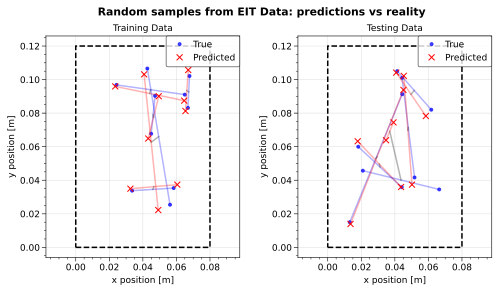

In [40]:
fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Random samples from EIT Data: predictions vs reality')
ax_train.set_title('Training Data')
ax_train.set_xlabel('x position [m]')
ax_train.set_ylabel('y position [m]')
ax_test.set_title('Testing Data')
ax_test.set_xlabel('x position [m]')
ax_test.set_ylabel('y position [m]')
ax_train.set_xlim([0, FRAME_X])
ax_train.set_ylim([0, FRAME_Y])
ax_test.set_xlim([0, FRAME_X])
ax_test.set_ylim([0, FRAME_Y])

best_model = load_model('models-4-dof/fcnn_2_finger.keras',
                        custom_objects={'custom_loss': unordered_mse})

# choose 5 random rows from the training and testing sets each
samples_i = np.random.choice(X_train.shape[0], 5, replace=False)
X_sample_train = X_train.iloc[samples_i].values
y_sample_train = y_pos_train.iloc[samples_i].values
y_pred_train = best_model.predict(X_sample_train)

samples_i = np.random.choice(X_test.shape[0], 5, replace=False)
X_sample_test = X_test.iloc[samples_i].values
y_sample_test = y_pos_test.iloc[samples_i].values
y_pred_test = best_model.predict(X_sample_test)

# plot training data
ax_train.plot(y_sample_train[:, 0], y_sample_train[:, 2], 'b.', label=f'True', alpha=0.7)  # first true point
ax_train.plot(y_sample_train[:, 1], y_sample_train[:, 3], 'b.', alpha=0.7)  # second true point
for i in range(len(y_sample_train)):
    ax_train.plot([y_sample_train[i, 0], y_sample_train[i, 1]], [y_sample_train[i, 2], y_sample_train[i, 3]],
        'b-', alpha=0.3)
ax_train.plot(y_pred_train[:, 0], y_pred_train[:, 2], 'rx', label=f'Predicted')  # first predicted point
ax_train.plot(y_pred_train[:, 1], y_pred_train[:, 3], 'rx')  # second predicted point
for i in range(len(y_sample_train)):
    ax_train.plot([y_pred_train[i, 0], y_pred_train[i, 1]], [y_pred_train[i, 2], y_pred_train[i, 3]],
        'r-', alpha=0.3)
for i in range(len(y_sample_train)):
    ax_train.plot([(y_sample_train[i, 0] + y_sample_train[i, 1]) / 2, (y_pred_train[i, 0] + y_pred_train[i, 1]) / 2],
        [(y_sample_train[i, 2] + y_sample_train[i, 3]) / 2, (y_pred_train[i, 2] + y_pred_train[i, 3]) / 2],
        'k-', alpha=0.3)
    
# plot testing data
ax_test.plot(y_sample_test[:, 0], y_sample_test[:, 2], 'b.', label=f'True', alpha=0.7)  # first true point
ax_test.plot(y_sample_test[:, 1], y_sample_test[:, 3], 'b.', alpha=0.7)  # second true point
for i in range(len(y_sample_test)):
    ax_test.plot([y_sample_test[i, 0], y_sample_test[i, 1]], [y_sample_test[i, 2], y_sample_test[i, 3]],
        'b-', alpha=0.3)
ax_test.plot(y_pred_test[:, 0], y_pred_test[:, 2], 'rx', label=f'Predicted')  # first predicted point
ax_test.plot(y_pred_test[:, 1], y_pred_test[:, 3], 'rx')  # second predicted point
for i in range(len(y_sample_test)):
    ax_test.plot([y_pred_test[i, 0], y_pred_test[i, 1]], [y_pred_test[i, 2], y_pred_test[i, 3]],
        'r-', alpha=0.3)
for i in range(len(y_sample_test)):
    ax_test.plot([(y_sample_test[i, 0] + y_sample_test[i, 1]) / 2, (y_pred_test[i, 0] + y_pred_test[i, 1]) / 2],
        [(y_sample_test[i, 2] + y_sample_test[i, 3]) / 2, (y_pred_test[i, 2] + y_pred_test[i, 3]) / 2],
        'k-', alpha=0.3)
    
# draw frames
ax_train.plot([0, FRAME_X, FRAME_X, 0, 0], [0, 0, FRAME_Y, FRAME_Y, 0], 'k--')
ax_train.axis('equal')
ax_train.legend(loc='upper right')
ax_test.plot([0, FRAME_X, FRAME_X, 0, 0], [0, 0, FRAME_Y, FRAME_Y, 0], 'k--')
ax_test.axis('equal')
ax_test.legend(loc='upper right')

plt.subplots_adjust(wspace=0.3)
plt.show()